In [1]:
from __future__ import print_function
import json
import zipfile
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import plot_roc_curve

# from scipy import stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import lightgbm as lgb
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error

from sklearn import metrics
from math import cos, sin, sqrt, pi
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline, make_pipeline
from IPython.display import Image  
from sklearn.externals.six import StringIO
from sklearn.tree import export_graphviz
from subprocess import call
import pydotplus

from sklearn.model_selection import GridSearchCV
# import geopandas as gpd
import seaborn as sns
import re
import sys
import seaborn
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.feature_extraction.text import CountVectorizer
# from nltk.stem import PorterStemmer
# from nltk.stem import LancasterStemmer
# from nltk.tokenize import sent_tokenize, word_tokenize
# from sklearn.feature_selection import SelectPercentile, f_classif
# from sklearn.preprocessing import MultiLabelBinarizer
# porter = PorterStemmer()
# lancaster=LancasterStemmer()

sns.set_style('darkgrid')
from shapely.geometry import Point, Polygon

%matplotlib inline

/opt/anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


In [2]:
# # # read data
# train_data = pd.read_csv('train.csv').drop('Unnamed: 0', 1)
# test_data = pd.read_csv('test.csv').drop('Unnamed: 0', 1)
# # test_data.head()

# further process the training data
# def computeCoordinateX(lat, lon):
#     return cos(lat)*cos(lon)
# getx = np.vectorize(computeCoordinateX)
# def computeCoordinateY(lat, lon):
#     return cos(lat)*sin(lon)
# gety = np.vectorize(computeCoordinateY)
# def getPriceOverRooms(price, bathroom, bedroom):
#     return price/(1+bedroom+bathroom)
# getRatio = np.vectorize(getPriceOverRooms)

# # x = train_data.drop(['latitude', 'longitude'], 1)

# #sample low interest data
# # x_low = x[x['interest_level']==0].sample(frac=0.8)
# # x_other = x[x['interest_level']!=0]
# # x = x_other.append(x_low, ignore_index = True) 

# y = train_data['interest_level']
# # x = train_data.drop(['interest_level'], 1)
# x = train_data
# #transform lat and lon
# x['Coor_X'] = getx(x['latitude'], x['longitude'])
# x['Coor_Y'] = gety(x['latitude'], x['longitude'])
# #compute price over rooms (less the better)
# x['PriceOverRooms'] = getRatio(x['price'], x['bathrooms'], x['bedrooms'])
# x = x.drop(['latitude', 'longitude', 'bathrooms', 'bedrooms'], 1)

#process test data
# listId = test_data['listing_id']
# x_test = test_data
# x_test['Coor_X'] = getx(x_test['latitude'], x_test['longitude'])
# x_test['Coor_Y'] = gety(x_test['latitude'], x_test['longitude'])
# x_test = test_data.drop(['latitude', 'longitude'], 1)
# x_test['PriceOverRooms'] = getRatio(x_test['price'], x_test['bathrooms'], x_test['bedrooms'])
# x_test = x_test.drop(['bathrooms', 'bedrooms'], 1)

# x.to_csv('train_1ver.csv')
# x_test.to_csv('test_1ver.csv')

# X = x.copy()
# Ncols = X.shape[1]

# # y = y.astype('category')
# # y = y.cat.codes
# x.head()
# X.shape

In [3]:
# read data
train_data = pd.read_csv('train_2ver.csv').drop('Unnamed: 0', 1)
test_data = pd.read_csv('test_2ver.csv').drop('Unnamed: 0', 1)
# train_data.head()
y = train_data['interest_level']
x = train_data.drop(['interest_level'], 1)

X = x.copy()
Ncols = X.shape[1]
x.head()

,bathrooms,bedrooms,latitude,longitude,price,num_photos,num_features,num_description_words,created_month,created_day,created_hour,Coor_X,Coor_Y,PriceOverRooms,num_furniture,total_days,diff_rank,price_latitue,price_longtitude
0,1.0,1,40.7108,-73.9539,2400,12,7,77,6,16,5,-0.125073,-0.983655,800.000000,2.0,76.20,0.000011,57.539055,-32.019681
1,1.0,2,40.7513,-73.9722,3800,6,6,131,6,1,5,-0.143691,-0.985587,950.000000,3.0,61.20,0.000009,91.015130,-50.685454
2,1.0,2,40.7575,-73.9625,3495,6,6,119,6,14,15,-0.134196,-0.987464,873.750000,3.0,74.60,0.000010,83.697539,-46.623312
3,1.5,3,40.7145,-73.9425,3000,5,0,95,6,24,7,-0.113906,-0.985486,545.454545,4.5,84.28,0.000012,71.917439,-40.030690
4,1.0,0,40.7439,-73.9743,2795,4,4,41,6,28,3,-0.145660,-0.984602,1397.500000,1.0,88.12,0.000012,66.955891,-37.279441


In [4]:
#split data and load into lgb dataset
X_train, X_valid, y_train, y_valid = train_test_split(X, y)
# lgb_train = lgb.Dataset(X_train, label=y_train)
# lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)
# param = {'objective' : 'multiclass','num_class':3,'metric':['multi_logloss'],'num_leaves': 31,
#     'learning_rate': 0.05,
#     'feature_fraction': 0.9,
#     'bagging_fraction': 0.8,
#     'bagging_freq': 5 }

#training and tune params
gbm_model = lgb.LGBMClassifier(boosting_type='gbdt',
                        num_leaves=31,
                        max_depth = 10,#10 8
                        learning_rate=0.1,#0.1 0.08 0.05
                        n_estimators=200,
                        objective='multiclass')

# 31, 10, 0.1 ,200 ,logloss:0.600


gbm_model.fit(X_train, y_train,
            eval_set=[(X_valid, y_valid)],
            eval_metric=['multi_logloss'],
            early_stopping_rounds=5,
            verbose=False)
# gbm_model = lgb.train(param, lgb_train, valid_sets=lgb_eval,verbose_eval=False)

#default params:
'''(boosting_type='gbdt', num_leaves=31, max_depth=-1, learning_rate=0.1, n_estimators=100, 
    subsample_for_bin=200000, objective=None, class_weight=None, min_split_gain=0.0, min_child_weight=0.001, 
    min_child_samples=20, subsample=1.0, subsample_freq=0, colsample_bytree=1.0, reg_alpha=0.0, 
    reg_lambda=0.0, random_state=None, n_jobs=-1, silent=True, importance_type='split', **kwargs)
'''

"(boosting_type='gbdt', num_leaves=31, max_depth=-1, learning_rate=0.1, n_estimators=100, \n    subsample_for_bin=200000, objective=None, class_weight=None, min_split_gain=0.0, min_child_weight=0.001, \n    min_child_samples=20, subsample=1.0, subsample_freq=0, colsample_bytree=1.0, reg_alpha=0.0, \n    reg_lambda=0.0, random_state=None, n_jobs=-1, silent=True, importance_type='split', **kwargs)\n"

In [5]:
#perform cross validation
scores = cross_val_score(gbm_model, X, y, cv=5, scoring='accuracy')
print("score is:", scores.mean(), '\n')

score is: 0.738349019203966 



In [6]:
#predict and evaluate on validation set
y_pred = gbm_model.predict(X_valid, num_iteration=gbm_model.best_iteration_)
# y_result = []
# for i in y_pred:
#     y_result.append(np.argmax(i))
# print(y_result)
# print(y_pred)
# print(y_valid)
# print(accuracy_score(y_valid, y_pred))
# print(mean_squared_error(y_valid, y_pred) ** 0.5)
print("trainning vs. validation score: ", gbm_model.score(X_train, y_train), gbm_model.score(X_valid, y_valid))
print("classification report:\n ", classification_report(y_valid , gbm_model.predict(X_valid)))

trainning vs. validation score:  0.8000517107644575 0.73931402964495
classification report:
                precision    recall  f1-score   support

        high       0.48      0.21      0.29       767
         low       0.80      0.93      0.86      8203
      medium       0.47      0.30      0.37      2634

    accuracy                           0.74     11604
   macro avg       0.58      0.48      0.51     11604
weighted avg       0.70      0.74      0.71     11604



In [7]:
# predict test data and output for submit to Kaggle
x_test = test_data.drop('listing_id', 1)
result = gbm_model.predict_proba(x_test)
submit = pd.DataFrame({'listing_id':test_data['listing_id'], 'high': result[:,0], 'medium':result[:,2], 'low':result[:,1]})

submit.to_csv('submission.csv',index = False)

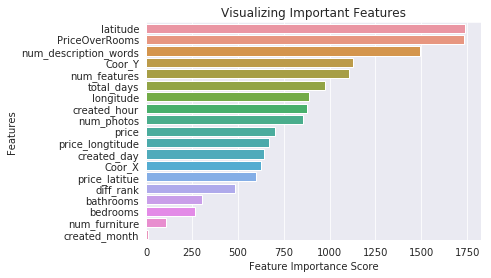

In [8]:
# show important features computed by lightGBM
#cite: https://www.datacamp.com/community/tutorials/random-forests-classifier-python

feature_rank = pd.Series(gbm_model.feature_importances_,index=X.columns).sort_values(ascending=False)
# Creating a bar plot
sns.barplot(x=feature_rank, y=feature_rank.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
# plt.legend()
plt.show()

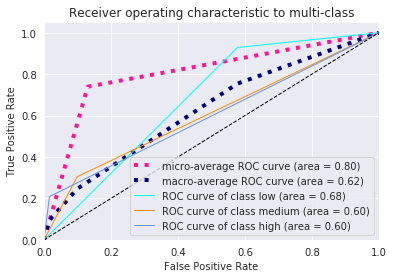

In [9]:
# apply ROC metrics of decision tree
# cite: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
# X = x.copy()
# y = train_data['interest_level']
# y = label_binarize(y, classes=['low', 'medium', 'high'])

# n_classes = y.shape[1]

# X_train, X_valid, y_train, y_valid = train_test_split(X, y)
# model = RandomForestClassifier(n_estimators=1000, max_depth=10, min_samples_leaf=10)
# model = DecisionTreeClassifier(max_depth=10, min_samples_leaf = 10)
model = gbm_model
# dt_model.fit(X_train, y_train)

# model = Pipeline([
# #         ('normalization', MinMaxScaler(feature_range = (0,1))),
# #         ('feature_selection', SelectKBest(f_classif, k=3)),
#         ('decision tree', DecisionTreeClassifier())
# ])
y_valid = label_binarize(y_valid, classes=['low', 'medium', 'high'])
y_score = label_binarize(y_pred, classes=['low', 'medium', 'high'])
n_classes = y_score.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_valid[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_valid.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# # Plot of a ROC curve for a specific class
# plt.figure()
lw = 1
# plt.plot(fpr[2], tpr[2], color='darkorange',
#          lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
# plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic example')
# plt.legend(loc="lower right")
# plt.show()

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
classes = ['low', 'medium', 'high']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classes[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()